<a href="https://colab.research.google.com/github/aml-spring-19/homework-5-cv5/blob/master/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import keras

# plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# processing & model selection
from keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit

# models
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, BatchNormalization, Dropout, Input, add
from keras.wrappers.scikit_learn import KerasClassifier

# other
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

# Homework 5

## Task 1

Task is to run a multilayer perceptron with two hidden layers and relu activations, using the Keras Sequential Interface. We also tune for regularization strength and number of hidden units. 

Importing the data:

In [0]:
df = sns.load_dataset('iris')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Map the target variable:

In [0]:
print(df.species.unique())

['setosa' 'versicolor' 'virginica']


In [0]:
mapping = {'setosa': 0, 'versicolor': 1, 'virginica': 2}
df.species.replace(mapping, inplace = True)

Split our dataset into training and test sets. 

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('species', axis=1), df.species, test_size=0.2)

Encode the target:

In [0]:
num_species = len(df['species'].unique())

y_train = to_categorical(y_train, num_species)
y_test = to_categorical(y_test, num_species)

Make our model:

In [0]:
X_train.shape

(120, 4)

In [0]:
def make_model(hidden_size, reg_strength, optimizer='adam'):
    """
    Create the model to pass to the Keras Classifier
    """
    
    model = Sequential([
        Dense(hidden_size, input_shape=(4,), activation='relu',   # first layer
              kernel_regularizer=regularizers.l2(reg_strength)),
        Dense(hidden_size, activation='relu',                     # second layer
              kernel_regularizer=regularizers.l2(reg_strength)),
        Dense(3, activation='softmax')                            # output layer
    ])
    
    # compile the above model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

Before proceeding any further, we should initialize the cross-validation method to be used in the grid search later on. 

In [0]:
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

In [0]:
clf = KerasClassifier(make_model, epochs=10, verbose=0)

param_grid = {'hidden_size': [32, 64, 128],
              'reg_strength': np.logspace(-3, -1, 5)}

grid = GridSearchCV(clf, param_grid=param_grid, cv=sss, n_jobs=-1)
grid.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=42, test_size=0.2,
            train_size=None),
       error_score='raise-deprecating',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f8c6da0a588>,
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'hidden_size': [32, 64, 128], 'reg_strength': array([0.001  , 0.00316, 0.01   , 0.03162, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
print('Best score: {}'.format(np.round(grid.best_score_, 2)))
print('Best params: {}'.format(grid.best_params_))

Best score: 0.97
Best params: {'hidden_size': 128, 'reg_strength': 0.0031622776601683794}


In [0]:
score = grid.score(X_test, y_test)
print('Test score: {}'.format(np.round(score, 2)))

Test score: 0.97


## Task 2

Train a multilayer perceptron (fully connected) on the Fashion MNIST dataset. 
1. Use 10000 samples from the training set for model selection and to compute learning curves (accuracy vs epochs).
2. Compare the following models and plot their learning curves:
    - Vanilla Model
    - Model using dropout
    - Model using batch normalization and residual connections (but no dropout)





In [0]:
# loading the data
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [3]:
print('Training size: {}, Test size: {}'.format(X_train.shape[0],X_test.shape[0]))
print('Each image has a shape of: {}x{}'.format(X_train.shape[1], X_train.shape[2]))

Training size: 60000, Test size: 10000
Each image has a shape of: 28x28


Before proceeding with the modeling, we have to process our data accordingly. 

In [0]:
# reshape X and cast to float
X_train = X_train.reshape(60000, 784); X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32'); X_test = X_test.astype('float32')

# scale X
X_train /= 255; X_test /= 255

# encode the target accordingly
n_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, n_classes); y_test = to_categorical(y_test, n_classes)

We also have to get a stratified sample of size 10000 from the training set for model selection.

In [0]:
X, X_valid, y, y_valid = train_test_split(X_train, y_train, stratify=y_train, random_state=6)

In [0]:
# sss = StratifiedShuffleSplit(n_splits=1, test_size=1/6, random_state=6)
# for a, b in sss.split(X_train, y_train):
#     X_sample, y_sample = X_train[b], y_train[b]

### Parameter Tuning

In [0]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=410)

**Vanilla Model**

We start off by tuning our vanilla model. Vanilla models are typically used to describe simple networks with 1 layer, so we'll only look at optimizing the number of hidden units in this case. 

In [0]:
def make_model(hidden_size):
    """
    Create the model to pass to the Keras Classifier
    """
    
    model = Sequential([
        Dense(hidden_size, input_shape=(784,), activation='relu'), # first layer
        Dense(10, activation='softmax')                            # output layer
    ])
    
    # compile the above model
    model.compile(optimizer='adam', loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [8]:
clf = KerasClassifier(make_model, epochs=10, verbose=0)

param_grid = {'hidden_size': [256, 512]}

grid = GridSearchCV(clf, param_grid=param_grid, cv=sss, n_jobs=-1).fit(X, y)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [9]:
print('VANILLA MODEL TUNING:')
print('Best Score: {}'.format(np.round(grid.best_score_, 2)))
print('Best Hidden Size: {}'.format(grid.best_params_['hidden_size']))

VANILLA MODEL TUNING:
Best Score: 0.89
Best Hidden Size: 256


In [0]:
vanilla = grid.best_estimator_
history_vanilla = vanilla.fit(X, y, epochs=10, validation_data=(X_valid, y_valid))

**Bigger Model w/ Dropout**

We can now proceed with tuning our bigger model with dropout. 

In [0]:
def make_model(hidden_size, hidden_layers, dp_p):
    """
    Create the model to pass to the Keras Classifier
    """
    model = Sequential()
    
    # input layer
    model.add(Dense(hidden_size, input_shape=(784,), activation='relu'))
    model.add(Dropout(dp_p))
    
    # add as many layers as needed
    for i in range(hidden_layers):
        model.add(Dense(hidden_size, activation='relu')) 
        model.add(Dropout(dp_p))  
    
    # output layer
    model.add(Dense(10, activation='softmax'))
    
    
    # compile the above model
    model.compile(optimizer='adam', loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [18]:
clf = KerasClassifier(make_model, epochs=10, verbose=0)

param_grid = {'hidden_size': [256, 512],
              'hidden_layers': [1,2,3],
              'dp_p': np.linspace(0.25, 0.75, 3)}

grid = GridSearchCV(clf, param_grid=param_grid, cv=sss, n_jobs=-1).fit(X, y)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
print('DROPOUT MODEL TUNING:')
print('Best Score: {}'.format(np.round(grid.best_score_, 2)))
print('Best Hidden Size: {}'.format(grid.best_params_['hidden_size']))
print('Best Number of Hidden Layers: {}'.format(grid.best_params_['hidden_layers']))
print('Best Dropout Prob: {}'.format(grid.best_params_['dp_p']))

DROPOUT MODEL TUNING:
Best Score: 0.89
Best Hidden Size: 512
Best Number of Hidden Layers: 1
Best Dropout Prob: 0.25


In [0]:
dropout = grid.best_estimator_
history_dropout = dropout.fit(X, y, epochs=10, validation_data=(X_valid, y_valid))

**Residual Batch Model**

Moving on to our final model for this task - we introduce batch normalization and residual connections. 

In [0]:
inputs = Input(shape=(784,))                 # input

x1 = Dense(256, activation='relu')(inputs)   # first layer: 256 units

x2 = Dense(256, activation='relu')(x1)       # second layer: 256 units
x2 = BatchNormalization()(x2)                # batch normalization
x2 = add([x1, x2])                           # residual connection

x3 = Dense(256, activation='relu')(x2)       # second layer: 256 units
x3 = BatchNormalization()(x3)                # batch normalization
x3 = add([x2, x3])                           # residual connection 

preds = Dense(10, activation='softmax')(x3)

resbatch = Model(inputs=inputs, outputs=preds)

In [0]:
resbatch.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_resbatch = resbatch.fit(X, y, epochs=10, validation_data=(X_valid, y_valid), verbose=0)

### Learning Curves

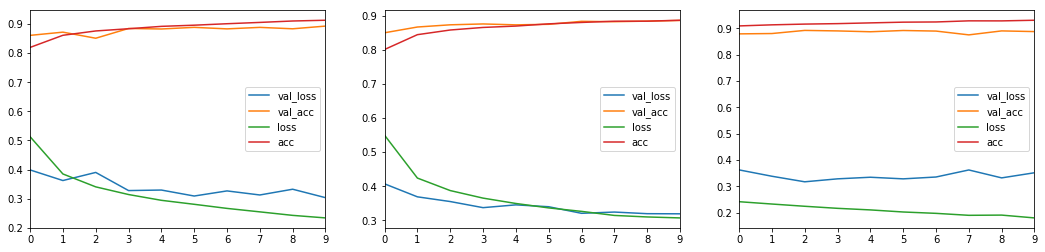

In [33]:
fig, ax = plt.subplots(1,3, figsize=(18, 4))
pd.DataFrame(history_vanilla.history).plot(ax=ax[0])
pd.DataFrame(history_dropout.history).plot(ax=ax[1])
pd.DataFrame(history_resbatch.history).plot(ax=ax[2])
plt.show()